In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
url = 'https://raw.githubusercontent.com/mkusman1/Aicadium_interview_question_Madi_Kusmanov/main/coding_round_data.csv?token=GHSAT0AAAAAABQOKWX7MZKP4AQOVRU37OOIYP2UIHA'
df = pd.read_csv(url)

# Data exploration and Feature engineering

In [4]:
# Check if there are any missing values
df_null = df.isnull().sum()
print(df_null)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [5]:
# Chack datatypes for each feature for label concoding
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [6]:
# Perform Label Encoding on bool and object type features
ordinal_encoder = OrdinalEncoder()
# object type
df['Month'] = ordinal_encoder.fit_transform(df[['Month']])

label_encoder = LabelEncoder()
# object type
df['VisitorType'] = label_encoder.fit_transform(df['VisitorType'])
# bool type
df['Weekend'] = label_encoder.fit_transform(df['Weekend'])
df['Revenue'] = label_encoder.fit_transform(df['Revenue'])

<AxesSubplot:>

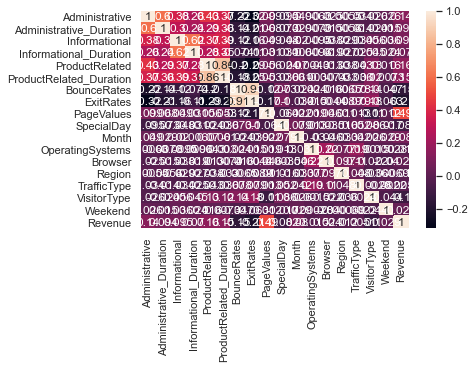

In [7]:
# Create a correlation matrix to inspect multicollinearity
corrMatrix = df.corr()
sns.set()
sns.heatmap(corrMatrix, annot=True)


Based on correlation heatmap multiple features are correlated: 
- ProductRelated and ProductRelated_Duration| 0.86
- Administrative and Administrative_Duration | 0.6
- Informational and Informational_Duration | 0.62

Therefore, in order to address the mutlicollinearity, I combined pairs in form 

- X_new = X1*X2

Other ways to address this porblem is to either drop one of the variables for each pair or construct better instrumental (dummy variablle).

In [8]:
# Combine highly correlated feature pairs into one 
df['ProductRelated_rate'] = df['ProductRelated']*(df['ProductRelated_Duration'])
df['Administrative_rate'] = df['Administrative']*(df['Administrative_Duration'])
df['Informational_rate'] = df['Informational']*(df['Informational_Duration'])

# Drop original features
df = df.drop(['ProductRelated', 'ProductRelated_Duration', 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration'], axis=1)

In [9]:
df.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue', 'ProductRelated_rate', 'Administrative_rate',
       'Informational_rate'],
      dtype='object')

In [10]:
df.head(10)

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,ProductRelated_rate,Administrative_rate,Informational_rate
0,0.200000,0.200000,0.0,0.0,2.0,1,1,1,1,2,0,0,0.000000,0.0,0.0
1,0.000000,0.100000,0.0,0.0,2.0,2,2,1,2,2,0,0,128.000000,0.0,0.0
2,0.200000,0.200000,0.0,0.0,2.0,4,1,9,3,2,0,0,0.000000,0.0,0.0
3,0.050000,0.140000,0.0,0.0,2.0,3,2,2,4,2,0,0,5.333333,0.0,0.0
4,0.020000,0.050000,0.0,0.0,2.0,3,3,1,4,2,1,0,6275.000000,0.0,0.0
5,0.015789,0.024561,0.0,0.0,2.0,2,2,1,3,2,0,0,2930.116667,0.0,0.0
6,0.200000,0.200000,0.0,0.4,2.0,2,4,3,3,2,0,0,0.000000,0.0,0.0
7,0.200000,0.200000,0.0,0.0,2.0,1,2,1,5,2,1,0,0.000000,0.0,0.0
8,0.000000,0.100000,0.0,0.8,2.0,2,2,2,3,2,0,0,74.000000,0.0,0.0
9,0.000000,0.022222,0.0,0.4,2.0,2,4,1,2,2,0,0,2214.000000,0.0,0.0


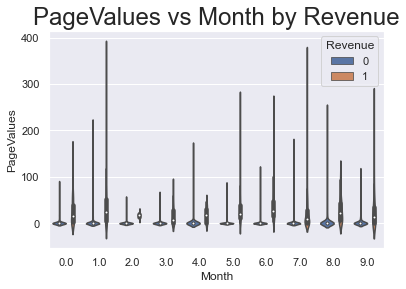

In [11]:
# Perform Multivariate analysis: violin plot for Page Values vs Month
sns.violinplot(x = df['Month'], y = df['PageValues'], hue = df['Revenue'], scale="count")
plt.title('PageValues vs Month by Revenue', fontsize = 24)
plt.show()

Here, we can observe revenue was generated for each month. Based on the violin plot, customers who viewed more product pages tend to make a purchase. Customers who did not generate revenue also had a low views of product pages. Moreover, certain months like February, April and May have lower number of customers who generated revenue. 

# Model

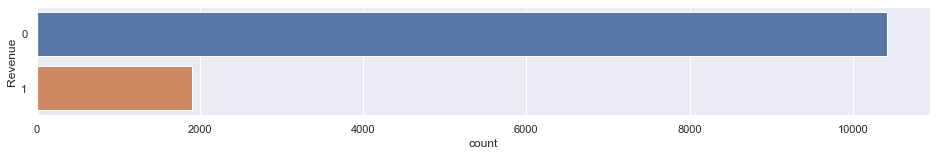

In [12]:
# Checking the balance of prediction labels
plt.figure(figsize=(16,2))
fig = sns.countplot(y="Revenue", data=df)
plt.show()

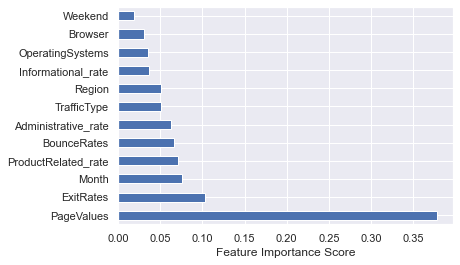

In [13]:
# Separate target variable from features
X = df.drop(['Revenue'], axis=1)
y = df['Revenue']

# Obtain feature importance score using class feature_importances of tree based classifiers
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators = 10, 
                             criterion ='entropy',
                             max_features = 12)
model.fit(X,y)
plt.figure()
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(12).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.show()

In [14]:
# Perfrom train test split for training and verification of the model: test size is 25% of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=0,
                                                    stratify=y
                                                   )

# Data normalization for training and testing features since the range of values varies drastically: used min max scaler
scalar = MinMaxScaler()
scalar.fit(X)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [17]:
X_test[1]

array([0.00000000e+00, 1.42857145e-01, 0.00000000e+00, 0.00000000e+00,
       8.88888889e-01, 1.42857143e-01, 8.33333333e-02, 3.75000000e-01,
       5.26315789e-02, 0.00000000e+00, 0.00000000e+00, 1.49823959e-06,
       3.12621296e-03, 0.00000000e+00])

In [13]:
# Define set of commonly used classifiers for this type of problems
# note: Random forest classifier has optimized parameters: see next section
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter = 700),
    "K Nearest Neighbour": KNeighborsClassifier(),
    "Support Vector Classification": SVC(max_iter = 700),
    "Decision Tree Classification": DecisionTreeClassifier(),
    "Random Forest Classification": RandomForestClassifier(bootstrap = False,
                                                          max_features = 'sqrt',
                                                          min_samples_leaf = 10),
    "MLPClassifier": MLPClassifier(learning_rate = 'adaptive', max_iter = 700)
    }

# Perform model training and display metrics
for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    print(key, "\n Accuracy:",accuracy_score(y_test,y_pred),"\n F-score",f1_score(y_test,y_pred))
    

Naive Bayes 
 Accuracy: 0.7836522867337009 
 F-score 0.48254460822342904
Logistic Regression 
 Accuracy: 0.8825819007460266 
 F-score 0.44135802469135804
K Nearest Neighbour 
 Accuracy: 0.8572818683100876 
 F-score 0.3393393393393393


/Users/madik/opt/anaconda3/envs/tensorflow_vscode/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=700).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Support Vector Classification 
 Accuracy: 0.5069737268893935 
 F-score 0.3298059964726631
Decision Tree Classification 
 Accuracy: 0.8705806033084658 
 F-score 0.572347266881029
Random Forest Classification 
 Accuracy: 0.9056114174505352 
 F-score 0.6531585220500596
MLPClassifier 
 Accuracy: 0.8942588387933831 
 F-score 0.6109785202863962


# Best Model 
Based on F1-score, Random Forest classifier showed the best performance: F1 = 0.6498. 

F1 score is used here to address the issue with the class imbalance: 84.5% (10,422) were negative class samples and (1908) were positive class samples.

# Optional: Model Tuning
Model tuning was performed using exhaustive search over specified parameter values for an estimator: GridSearchCV

Running the cell below takes time therefore this section is optional and resulted parameters were used in cell above.

In [14]:
# Define set of parameters of interest 
parameters = [{
    "max_features": ['auto', 'sqrt'],
    "min_samples_leaf": [1,5,10,15,20],
    "bootstrap": [True, False]
             }]

# Perform grid search over specified parameters
rf_grid_search = GridSearchCV(RandomForestClassifier(), 
                  parameters, 
                  cv=5, 
                  n_jobs=-1,
                  scoring='f1', 
                  verbose=True)

rf_grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'max_features': ['auto', 'sqrt'],
                          'min_samples_leaf': [1, 5, 10, 15, 20]}],
             scoring='f1', verbose=True)

In [15]:
# These values were used for initialization Random Forest classifier
print(rf_grid_search.best_params_)

{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 5}


In [16]:
### Create a Pickle file of best classifier to pass it to fastapi 
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(rf_grid_search, pickle_out)
pickle_out.close()